In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input,Conv2D
from tensorflow.keras.models import Sequential, Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras import ayers, model

In [ ]:
tmp=np.zeros((4,4))
print(tmp)
print('-'*30)
print(tmp.reshape(4,4,1))

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
------------------------------
[[[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  [0.]]]


### 1. 텐서플로우 데이터셋의 흑백 28,28 손글씨 자료 50개를 갖고와서  CNN에 넣기 위하여 28,28,1로 변형 

In [2]:
from tensorflow.keras import datasets, layers, models
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

#  CNN 은 무조건 3채널이어야함. 흑백 28,28 도 28,28,1로 변경해야함.
train_images = train_images.reshape((60000, 28, 28, 1))[:50]  # 샘플링으로 50개만
test_images = test_images.reshape((10000, 28, 28, 1))[:50]
train_labels=train_labels[:50]
test_labels=test_labels[:50]


11490434/11490434 [==============================] - 0s 0us/step


###  2. 학습의 편의성을 위하여 50개 이미지를 높이, 너비를 10,10 으로 변경


In [3]:
plt.figure(figsize=(15,3))
from skimage.transform import resize
train_images = resize(train_images, (50,10, 10,1)) # 28,28 을 10,10으로 크기 줄임. 넘파이로 되어있는 이미지 사이즈 조정
test_images = resize(train_images, (50,10, 10,1))
np.shape(train_images)



(50, 10, 10, 1)

<Figure size 1080x216 with 0 Axes>

(50, 10, 10)


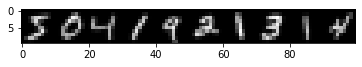

In [4]:
### plot모듈에서는 컬러(행,열,3)이거나, 흑백(행,열) 이어야함

tmp=train_images.reshape(50,10,10)    #넘파이 reshape
print(tmp.shape)
plt.imshow(np.hstack(tmp[:10]),cmap='gray')

In [5]:
pd.DataFrame(np.vstack(train_images[0]).reshape(10,10))

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.000000e+00,0.000000e+00,3.779813e-09,5.703982e-07,0.000004,1.042152e-05,0.000015,8.009369e-06,1.619335e-08
1,0.000000,3.493966e-07,7.807178e-04,7.999273e-03,2.619184e-02,0.059819,1.155171e-01,0.155306,7.679844e-02,1.519801e-04
2,0.000000,9.857660e-05,1.036307e-01,5.545328e-01,7.500384e-01,0.815209,6.413300e-01,0.491694,1.539254e-01,2.481732e-04
3,0.000000,2.617595e-05,5.656854e-02,4.300613e-01,8.046835e-01,0.233121,1.624373e-01,0.008346,1.218553e-03,5.837837e-07
4,0.000000,9.748591e-09,1.279662e-04,2.502775e-02,5.374982e-01,0.290856,3.380014e-02,0.000305,1.190274e-08,0.000000e+00
5,0.000000,0.000000e+00,6.266862e-09,2.610279e-04,6.696573e-02,0.564458,5.666593e-01,0.047100,1.411354e-05,0.000000e+00
6,0.000000,4.497760e-08,3.063738e-05,3.220381e-03,7.633813e-02,0.401042,8.656932e-01,0.157746,1.073702e-04,0.000000e+00
7,0.000008,5.200728e-03,7.889449e-02,3.434775e-01,7.748787e-01,0.739755,3.174749e-01,0.021589,2.289392e-06,0.000000e+00
8,0.000387,2.102920e-01,6.982965e-01,7.215174e-01,3.777502e-01,0.048582,1.853358e-03,0.000010,1.813034e-10,0.000000e+00
9,0.000029,1.430609e-02,3.384249e-02,1.997844e-02,1.852532e-03,0.000012,1.298005e-08,0.000000,0.000000e+00,0.000000e+00


### 3. 계산검증의 편의성을 위하여 float를 int로 변경

In [6]:
train_images=(train_images*10).astype('int32')
test_images=(test_images*10).astype('int32')
pd.DataFrame(np.vstack(train_images[0]).reshape(10,10))

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0
2,0,0,1,5,7,8,6,4,1,0
3,0,0,0,4,8,2,1,0,0,0
4,0,0,0,0,5,2,0,0,0,0
5,0,0,0,0,0,5,5,0,0,0
6,0,0,0,0,0,4,8,1,0,0
7,0,0,0,3,7,7,3,0,0,0
8,0,2,6,7,3,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0


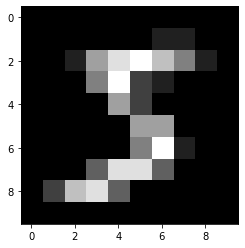

In [7]:
plt.imshow(train_images[0].reshape(10,10),cmap='gray')

### 4. CNN 모델 제작
- padding옵션을 안주면 valid가 되면서 일정량 이미지 사이즈가 줄어들지만
  일반적으로 same를 해서 이미지 사이즈를 줄어들지 않게함.
- 딥러닝 초창기에는 maxpooling을 필수로 사용함.
- 하드웨어 장비가 CNN 처리할때 부족해서 최대한 이미지를 줄임
- 하지만 요즘은 maxpooling을 하지 않음. 
  - model.add(layers.Flatten()) 할때 이미지 사이즈가 엄청 큼
  ---> flatten도 여러 가지 방법이 있게됨 (예: 가로세로4개중에서 평균취하기, 풀링하고같은) 

In [8]:
import tensorflow as tf
#tf.random.set_seed(123)
model = models.Sequential()
model.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=(10, 10, 1)))
model.add(layers.MaxPooling2D((2, 2)))   # 이미지 사이즈를 1/2로 줄이기 위해서 
model.add(layers.Conv2D(2, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(2, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 1)           10        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 1)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 2)           20        
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 2)                 18        
                                                                 
 dense_1 (Dense)             (None, 10)                30        
                                                        

In [10]:
import tensorflow as tf

get_layer_name = [layer.name for layer in model.layers]
get_output = [layer.output for layer in model.layers]
get_output

[<KerasTensor: shape=(None, 8, 8, 1) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 4, 4, 1) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 2, 2, 2) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense')>,
 <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense_1')>]

### 5. 모델 w값 setting

- model = models.Sequential()
- <font color='red'> model.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=(10, 10, 1))) </font>
-  model.add(layers.MaxPooling2D((2, 2)))
- model.add(layers.Conv2D(2, (3, 3), activation='relu'))

- model.add(layers.Flatten())
- model.add(layers.Dense(2, activation='relu'))
- model.add(layers.Dense(10, activation='softmax'))


In [ ]:
# 모델의 첫번째 레이어만 사용
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output[0])
visual_model.summary()      
test_img = np.expand_dims(test_images[0], axis = 0)  # 텐서단위로 변환.  test_images[0].reshape(1,10,10,1)
feature_maps = visual_model.predict(test_img)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer)  [(None, 10, 10, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 1)           10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [ ]:
len(visual_model.get_weights()),\
visual_model.get_weights()[0],\
visual_model.get_weights()[1]


(2, array([[[[ 0.46669114]],
 
         [[-0.11140621]],
 
         [[ 0.51596   ]]],
 
 
        [[[ 0.04655355]],
 
         [[ 0.41350287]],
 
         [[ 0.30145288]]],
 
 
        [[[ 0.46068835]],
 
         [[ 0.52773476]],
 
         [[ 0.08137858]]]], dtype=float32), array([0.], dtype=float32))

In [ ]:
setW =np.array( [[-0.4318703, 0.08380783, -0.23193197],
           [0.05313462, 0.25442973, 0.33345792],
           [-0.22227043, -0.02131751, 0.17737235]])
setB= np.array([-0.00019932])


setW=setW.reshape(3,3,1,1)
weights =setW,setB
visual_model.set_weights(weights)

In [ ]:
### 검증을 위한 w,b값 출력
w=visual_model.get_weights()[0]   
b=visual_model.get_weights()[1]  
np.shape(w),np.vstack(w).reshape(3,3),b

((3, 3, 1, 1),
 array([[-0.4318703 ,  0.08380783, -0.23193197],
        [ 0.05313462,  0.25442973,  0.33345792],
        [-0.22227043, -0.02131751,  0.17737235]], dtype=float32),
 array([-0.00019932], dtype=float32))

### 6. 모델 결과 계산 (feature_maps 계산)

In [ ]:
# 파이썬에서 직접 계산하여 봅니다.
wVal=np.vstack(w).reshape(3,3)
img=np.vstack(train_images[0]).reshape(10,10)
img[:3,:3]*wVal, np.sum(img[:3,:3]*wVal)+b

(array([[-0.        ,  0.        , -0.        ],
        [ 0.        ,  0.        ,  0.        ],
        [-0.        , -0.        ,  0.17737235]]),
 array([0.17717303], dtype=float32))

In [ ]:
# 파이썬에서 직접 계산하여 봅니다.
wVal=np.vstack(w).reshape(3,3)
img=np.vstack(train_images[0]).reshape(10,10)
print('▶--- 0:3, 0:3 에서 스트라이드 1한  높이 0:3, 너비 1:4 인덱싱값 ')
print(img[0:3, 1:4])

print('\n▶-- img[0:3, 1:4] * w')
print(img[0:3,1:4]*wVal)
      
print('\n▶-- img[0:3, 1:4] * w의 합 + b')      
np.sum(img[0:3,1:4]*wVal)+b

▶--- 0:3, 0:3 에서 스트라이드 1한  높이 0:3, 너비 1:4 인덱싱값 
[[0 0 0]
 [0 0 0]
 [0 1 5]]

▶-- img[0:3, 1:4] * w
[[-0.          0.         -0.        ]
 [ 0.          0.          0.        ]
 [-0.         -0.02131751  0.88686176]]

▶-- img[0:3, 1:4] * w의 합 + b


array([0.86534494], dtype=float32)

### 7. 모델 최종값 계산- Relu 함수에 의해서 – 값은 0으로 변경됨

,0,1,2,3,4,5,6,7
0,0.177564,0.866703,0.915288,0.162334,0.000000,0.000000,0.000000,0.000000
1,0.333655,2.633160,4.998099,4.016185,2.539292,2.676035,1.102396,0.036261
2,0.000000,0.259959,2.941794,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.150432,1.310135,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,2.335093,2.287068,0.000000,0.000000,0.000000
5,0.000000,0.532693,1.179595,0.604863,1.779490,0.000000,0.000000,0.053328
6,1.023149,1.673063,2.151912,1.733192,0.972616,0.000000,0.000000,0.000000
7,2.511186,3.274817,1.733227,0.000000,0.000000,0.000000,0.000000,0.000000


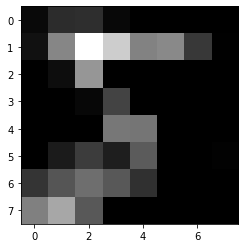

In [ ]:
## 최종출력
len(feature_maps[0][0])
plt.imshow(feature_maps[0],cmap='gray')
pd.DataFrame(np.vstack(feature_maps[0]).reshape(8,8))

In [ ]:
layer0=feature_maps.copy()

### 8. Pooling 레이어 값 확인
- model = models.Sequential()
- model.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=(10, 10, 1)))
- <font color='red'> model.add(layers.MaxPooling2D((2, 2))) </fon>
- model.add(layers.Conv2D(2, (3, 3), activation='relu'))

- model.add(layers.Flatten())
- model.add(layers.Dense(2, activation='relu'))
- model.add(layers.Dense(10, activation='softmax'))



In [ ]:
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output[1])
visual_model.summary()     
test_img = np.expand_dims(test_images[0], axis = 0)
feature_maps = visual_model.predict(test_img)

NameError: ignored

In [ ]:
maxpoolResult=np.vstack(feature_maps[0].reshape(4,4))
maxpoolResult

NameError: ignored

In [ ]:
plt.imshow(feature_maps[0],cmap='gray')
plt.show()
pd.DataFrame(np.vstack(feature_maps[0]).reshape(4,4))

### 9. Layer2
- model = models.Sequential()
- model.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=(10, 10, 1))) 
- model.add(layers.MaxPooling2D((2, 2)))
- <font color='red'> model.add(layers.Conv2D(2, (3, 3), activation='relu'))</font>

- model.add(layers.Flatten())
- model.add(layers.Dense(2, activation='relu'))
- model.add(layers.Dense(10, activation='softmax'))

In [ ]:
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output[2])
visual_model.summary()  
test_img = np.expand_dims(test_images[0], axis = 0)
feature_maps = visual_model.predict(test_img)

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 1)           10        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 2)           20        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(len(visual_model.get_weights()))
w=visual_model.get_weights()[0]     
b=visual_model.get_weights()[1]
print(np.vstack(w).reshape(3,3),b)
print(np.shape(w), np.shape(b))
print('-'*100)
w=visual_model.get_weights()[2]
b=visual_model.get_weights()[3]
print(w,b)

4
[[-0.4318703   0.08380783 -0.23193197]
 [ 0.05313462  0.25442973  0.33345792]
 [-0.22227043 -0.02131751  0.17737235]] [-0.00019932]
(3, 3, 1, 1) (1,)
----------------------------------------------------------------------------------------------------
[[[[ 0.3674009  -0.35492098]]

  [[ 0.25632307  0.17448828]]

  [[ 0.13600942 -0.39838392]]]


 [[[ 0.2362543   0.11793062]]

  [[-0.46411705  0.05063149]]

  [[ 0.31956223 -0.05979198]]]


 [[[ 0.43049613  0.24405327]]

  [[ 0.37376186 -0.05215767]]

  [[-0.1655781  -0.14671475]]]] [0. 0.]


In [ ]:
setW =np.array( [[-0.4318703, 0.08380783, -0.23193197],
           [0.05313462, 0.25442973, 0.33345792],
           [-0.22227043, -0.02131751, 0.17737235]])
setB= np.array([-0.00019932])

w2=visual_model.get_weights()[2]
b2=visual_model.get_weights()[3]
setW=setW.reshape(3,3,1,1)

weights =[setW,setB,w2,b2]
visual_model.set_weights(weights)

In [ ]:
len(visual_model.get_weights())
w=visual_model.get_weights()[2]
b=visual_model.get_weights()[3]
w, b

(array([[[[ 0.3674009 , -0.35492098]],
 
         [[ 0.25632307,  0.17448828]],
 
         [[ 0.13600942, -0.39838392]]],
 
 
        [[[ 0.2362543 ,  0.11793062]],
 
         [[-0.46411705,  0.05063149]],
 
         [[ 0.31956223, -0.05979198]]],
 
 
        [[[ 0.43049613,  0.24405327]],
 
         [[ 0.37376186, -0.05215767]],
 
         [[-0.1655781 , -0.14671475]]]], dtype=float32),
 array([0., 0.], dtype=float32))

In [ ]:
### 전체 w,b값 확인
visual_model.get_weights()

[array([[[[-0.4318703 ]],
 
         [[ 0.08380783]],
 
         [[-0.23193197]]],
 
 
        [[[ 0.05313462]],
 
         [[ 0.25442973]],
 
         [[ 0.33345792]]],
 
 
        [[[-0.22227043]],
 
         [[-0.02131751]],
 
         [[ 0.17737235]]]], dtype=float32),
 array([-0.00019932], dtype=float32),
 array([[[[ 0.3674009 , -0.35492098]],
 
         [[ 0.25632307,  0.17448828]],
 
         [[ 0.13600942, -0.39838392]]],
 
 
        [[[ 0.2362543 ,  0.11793062]],
 
         [[-0.46411705,  0.05063149]],
 
         [[ 0.31956223, -0.05979198]]],
 
 
        [[[ 0.43049613,  0.24405327]],
 
         [[ 0.37376186, -0.05215767]],
 
         [[-0.1655781 , -0.14671475]]]], dtype=float32),
 array([0., 0.], dtype=float32)]

In [ ]:
# maxpooling을 거쳐 나온값인 maxpoolResult값하고 3,3 씩 곱하기함
maxpoolResult

array([[2.6310093 , 4.992998  , 2.6713052 , 1.0994523 ],
       [0.2577803 , 2.93569   , 0.        , 0.        ],
       [0.53191775, 2.331755  , 2.2812119 , 0.0529353 ],
       [3.2710578 , 2.146567  , 0.9660892 , 0.        ]], dtype=float32)

In [ ]:
f1=w[:,:,:,0]
f2=w[:,:,:,1]

print('maxpoolResult 값')
print(maxpoolResult[:3,:3])
print('\n▶피처1값','-'*100, )
print(f1.reshape(3,3))
print('\n▶피처2값','-'*100, )
print(f2.reshape(3,3))

print('\n▶[0:3,0:3]*피처1값+b[0]합','-'*50)
print(np.sum(maxpoolResult[:3,:3]*f1.reshape(3,3))+b[0])

print('\n▶[0:3,0:3]*피처2값+b[1]합','-'*50)
np.sum(maxpoolResult[:3,:3]*f2.reshape(3,3))+b[1]

maxpoolResult 값
[[2.6310093  4.992998   2.6713052 ]
 [0.2577803  2.93569    0.        ]
 [0.53191775 2.331755   2.2812119 ]]

▶피처1값 ----------------------------------------------------------------------------------------------------
[[ 0.3674009   0.25632307  0.13600942]
 [ 0.2362543  -0.46411705  0.31956223]
 [ 0.43049613  0.37376186 -0.1655781 ]]

▶피처2값 ----------------------------------------------------------------------------------------------------
[[-0.35492098  0.17448828 -0.39838392]
 [ 0.11793062  0.05063149 -0.05979198]
 [ 0.24405327 -0.05215767 -0.14671475]]

▶[0:3,0:3]*피처1값+b[0]합 --------------------------------------------------
2.0309672

▶[0:3,0:3]*피처2값+b[1]합 --------------------------------------------------


-1.2742374

In [ ]:
feature_maps

array([[[[2.0309675, 0.       ],
         [5.2099314, 0.       ]],

        [[2.6701632, 1.0097562],
         [1.8728051, 0.       ]]]], dtype=float32)

In [ ]:
f1=w[:,:,:,0]
f2=w[:,:,:,1]

print('maxpoolResult 값')
print(maxpoolResult[0:3,1:4])
print('\n▶피처1값','-'*100, )
print(f1.reshape(3,3))
print('\n▶피처2값','-'*100, )
print(f1.reshape(3,3))

print('\n▶[0:3,0:3]*피처1값+b[0]합','-'*50)
print(np.sum(maxpoolResult[0:3,1:4]*f1.reshape(3,3))+b[0])

print('\n▶[0:3,0:3]*피처2값+b[1]합','-'*50)
np.sum(maxpoolResult[0:3,1:4]*f2.reshape(3,3))+b[0]

maxpoolResult 값
[[4.992998  2.6713052 1.0994523]
 [2.93569   0.        0.       ]
 [2.331755  2.2812119 0.0529353]]

▶피처1값 ----------------------------------------------------------------------------------------------------
[[ 0.3674009   0.25632307  0.13600942]
 [ 0.2362543  -0.46411705  0.31956223]
 [ 0.43049613  0.37376186 -0.1655781 ]]

▶피처2값 ----------------------------------------------------------------------------------------------------
[[ 0.3674009   0.25632307  0.13600942]
 [ 0.2362543  -0.46411705  0.31956223]
 [ 0.43049613  0.37376186 -0.1655781 ]]

▶[0:3,0:3]*피처1값+b[0]합 --------------------------------------------------
5.2099314

▶[0:3,0:3]*피처2값+b[1]합 --------------------------------------------------


-0.9554814

In [ ]:
f1=w[:,:,:,0]
f2=w[:,:,:,1]

print('maxpoolResult 값')
print(maxpoolResult[1:4,0:3])
print('\n▶피처1값','-'*100, )
print(f1.reshape(3,3))
print('\n▶피처2값','-'*100, )
print(f2.reshape(3,3))


print('\n▶[0:3,0:3]*피처1값+b[0]합','-'*50)
print(np.sum(maxpoolResult[1:4,0:3]*f1.reshape(3,3))+b[0])

print('\n▶[0:3,0:3]*피처2값+b[1]합','-'*50)
np.sum(maxpoolResult[1:4,0:3]*f2.reshape(3,3))+b[0]

maxpoolResult 값
[[0.2577803  2.93569    0.        ]
 [0.53191775 2.331755   2.2812119 ]
 [3.2710578  2.146567   0.9660892 ]]

▶피처1값 ----------------------------------------------------------------------------------------------------
[[ 0.3674009   0.25632307  0.13600942]
 [ 0.2362543  -0.46411705  0.31956223]
 [ 0.43049613  0.37376186 -0.1655781 ]]

▶피처2값 ----------------------------------------------------------------------------------------------------
[[-0.35492098  0.17448828 -0.39838392]
 [ 0.11793062  0.05063149 -0.05979198]
 [ 0.24405327 -0.05215767 -0.14671475]]

▶[0:3,0:3]*피처1값+b[0]합 --------------------------------------------------
2.6701632

▶[0:3,0:3]*피처1값+b[0]합 --------------------------------------------------


1.0097562

In [ ]:
f1=w[:,:,:,0]
f2=w[:,:,:,1]

print('maxpoolResult 값')
print(maxpoolResult[1:4,1:4])
print('\n▶피처1값','-'*100, )
print(f1.reshape(3,3))
print('\n▶피처2값','-'*100, )
print(f1.reshape(3,3))

print('\n▶[0:3,0:3]*피처1값+b[0]합','-'*50)
print(np.sum(maxpoolResult[1:4,1:4]*f1.reshape(3,3))+b[0])

print('\n▶[0:3,0:3]*피처2값+b[1]합','-'*50)
np.sum(maxpoolResult[1:4,1:4]*f2.reshape(3,3))+b[0]

maxpoolResult 값
[[2.93569   0.        0.       ]
 [2.331755  2.2812119 0.0529353]
 [2.146567  0.9660892 0.       ]]

▶피처1값 ----------------------------------------------------------------------------------------------------
[[ 0.3674009   0.25632307  0.13600942]
 [ 0.2362543  -0.46411705  0.31956223]
 [ 0.43049613  0.37376186 -0.1655781 ]]

▶피처2값 ----------------------------------------------------------------------------------------------------
[[ 0.3674009   0.25632307  0.13600942]
 [ 0.2362543  -0.46411705  0.31956223]
 [ 0.43049613  0.37376186 -0.1655781 ]]

▶[0:3,0:3]*피처1값+b[0]합 --------------------------------------------------
1.8728052

▶[0:3,0:3]*피처2값+b[1]합 --------------------------------------------------


-0.1811288

In [ ]:
conv2=feature_maps
conv2

array([[[[2.0277953, 0.       ],
         [5.2068067, 0.       ]],

        [[2.667101 , 1.0083745],
         [1.870532 , 0.       ]]]], dtype=float32)

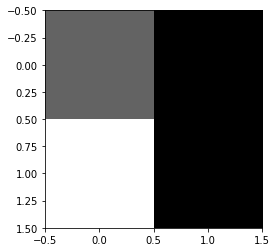

In [ ]:
plt.imshow(feature_maps[0][0], cmap='gray')

### 10. flatten

- model = models.Sequential()
- model.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=(10, 10, 1))) 
- model.add(layers.MaxPooling2D((2, 2)))
- model.add(layers.Conv2D(2, (3, 3), activation='relu'))

- <font color='red'>  model.add(layers.Flatten())</font>
- model.add(layers.Dense(2, activation='relu'))
- model.add(layers.Dense(10, activation='softmax'))

In [ ]:
### 
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output[3])
visual_model.summary()  
test_img = np.expand_dims(test_images[0], axis = 0)
feature_maps = visual_model.predict(test_img)


Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 1)           10        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 2)           20        
_________________________________________________________________
flatten_3 (Flatten)          (None, 8)                 0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [ ]:
len(visual_model.get_weights())

4

In [ ]:
feature_maps

array([[2.0309675, 0.       , 5.2099314, 0.       , 2.6701632, 1.0097562,
        1.8728051, 0.       ]], dtype=float32)

### 11. FNN

- model = models.Sequential()
- model.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=(10, 10, 1))) 
- model.add(layers.MaxPooling2D((2, 2)))
- model.add(layers.Conv2D(2, (3, 3), activation='relu'))

-   model.add(layers.Flatten())
- <font color='red'>model.add(layers.Dense(2, activation='relu')) </font>
- model.add(layers.Dense(10, activation='softmax'))

In [ ]:
### 
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output[4])
visual_model.summary()  
test_img = np.expand_dims(test_images[0], axis = 0)
feature_maps = visual_model.predict(test_img)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 1)           10        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 2)           20        
_________________________________________________________________
flatten_3 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 18        
Total params: 48
Trainable params: 48
Non-trainable params: 0
______________________________________________________________

In [ ]:
len(visual_model.get_weights())

6

In [ ]:
flatten

array([[2.0309675, 0.       , 5.2099314, 0.       , 2.6701632, 1.0097562,
        1.8728051, 0.       ]], dtype=float32)

In [ ]:
w=visual_model.get_weights()[4]
b=visual_model.get_weights()[5]
w,b

(array([[-1.6069949e-02,  1.3290888e-01],
        [-2.0988941e-01,  2.4020374e-01],
        [ 6.3130927e-01, -1.9275570e-01],
        [ 2.9161584e-01, -3.8134876e-01],
        [-3.3706427e-04,  1.9531548e-02],
        [ 3.5307527e-01,  1.3492244e-01],
        [ 6.2301373e-01,  6.4290762e-02],
        [-4.7030160e-01, -1.9889295e-02]], dtype=float32),
 array([0., 0.], dtype=float32))

In [ ]:
feature_maps

array([[4.7798467, 0.       ]], dtype=float32)

### 11. FNN

- model = models.Sequential()
- model.add(layers.Conv2D(1, (3, 3), activation='relu', input_shape=(10, 10, 1))) 
- model.add(layers.MaxPooling2D((2, 2)))
- model.add(layers.Conv2D(2, (3, 3), activation='relu'))

-   model.add(layers.Flatten())
- model.add(layers.Dense(2, activation='relu')) 
- <font color='red'>model.add(layers.Dense(10, activation='softmax'))</font>

In [ ]:
visual_model = tf.keras.models.Model(inputs = model.input, outputs = get_output[5])
visual_model.summary()  
test_img = np.expand_dims(test_images[0], axis = 0)
feature_maps = visual_model.predict(test_img)

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 10, 10, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 1)           10        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 1)           0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 2, 2, 2)           20        
_________________________________________________________________
flatten_3 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 18        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                30 

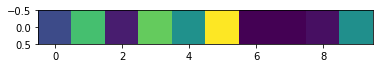

In [ ]:
plt.imshow(feature_maps)